## APC data analysis

### Below I briefly demonstrate how I analyze date (time lapse movie) to extract the mean dwell time. 

### 1) Read a movie file (*.tif) 
### 2) Create a maximum projection image
### 3) Find local maximum intensity spots
### 4) Get the intensity traces at each spots and normalize
### 5) Discard noisy signal
### 6) Lowpass filter and find the state using piecewise constant method
### 7) Find dwell time from each trace and combine them
### 8) Finally, obtain mean dwell time from the entire population 

Created on Wed Mar  6 07:49:41 2019 @author: Jongmin Sung

In [1]:
# Import library
from __future__ import division, print_function, absolute_import
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

## Read a movie file (*.tif) 

In [2]:
# Open a time lapse movie
filename = 'movie.tif'
movie = Image.open(filename)
n_frame = movie.n_frames
n_row = movie.size[1]
n_col = movie.size[0]
print('File name = ', filename)
print('[frame, row, col] = [%d, %d, %d] \n' %(n_frame, n_row, n_col))        

# Pixel intensity is saved in I[frame, row, col] 
I_frame = np.zeros((n_frame, n_row, n_col), dtype=int)
for i in range(n_frame): 
    movie.seek(i) # Move to i-th frame
    I_frame[i,] = np.array(movie, dtype=int)        

File name =  movie.tif
[frame, row, col] = [200, 310, 304] 



## Create a maximum projection image

Text(0.5, 1.0, 'Maximum intensity')

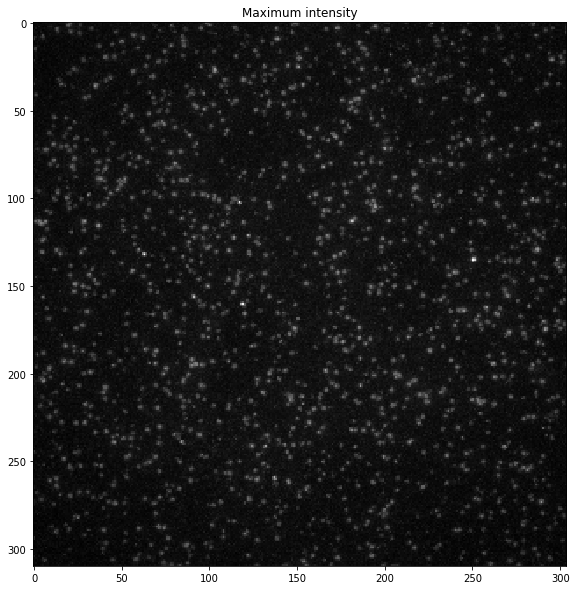

In [3]:
# Maximum projection         
I_max = np.max(I_frame, axis=0)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(I_max, cmap=cm.gray)
ax.set_title('Maximum intensity') 

## Find local maximum intensity peaks

Found 1429 spots. 


Text(0.5, 1.0, 'Peaks = 1429, Spot size = 3, Min_distance = 3')

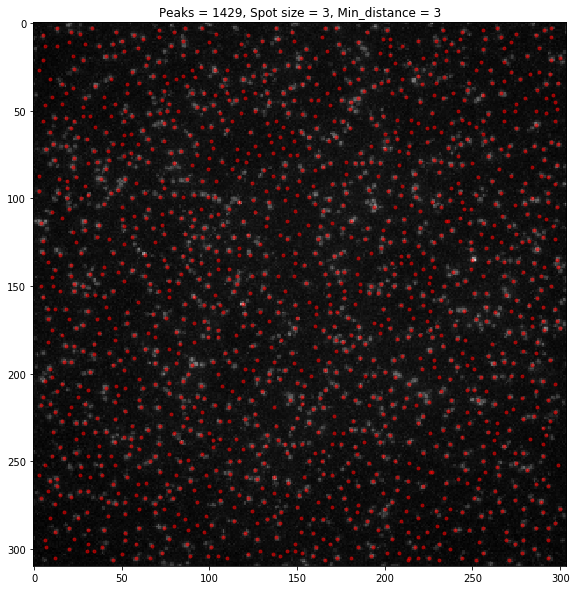

In [4]:
# Find peaks from local maximum
from skimage.feature import peak_local_max

spot_size = 3
min_distance = 3
peaks = peak_local_max(I_max, min_distance)        
n_peak = len(peaks[:, 1])
row = peaks[::-1,0]
col = peaks[::-1,1]
print('Found', n_peak, 'spots. ')    

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(I_max, cmap=cm.gray)
for i in range(n_peak):
    ax.plot(col[i], row[i], 'ro', ms=3, alpha=0.5)  
ax.set_title('Peaks = %d, Spot size = %d, Min_distance = %d' % (n_peak, spot_size, min_distance))  

## Get the intensity traces at each spot

Text(0.5, 1.0, 'Minimum intensity at each spot')

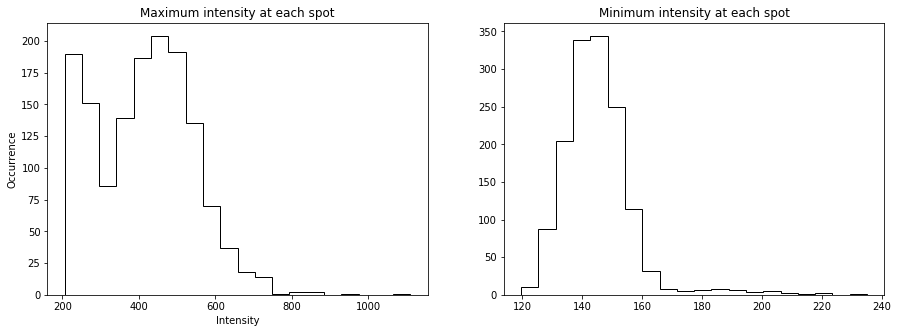

In [5]:
I_peak = ['None']*n_peak

s = int(spot_size/2)

for i in range(n_peak):
    I_peak[i] = np.mean(np.mean(I_frame[:,row[i]-s:row[i]+s,col[i]-s:col[i]+s], axis=2), axis=1) # Mean intensity around the peak

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))    
ax1.hist([I_peak[i].max() for i in range(n_peak)], 20, color='k', histtype='step', lw=1)
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Occurrence')
ax1.set_title('Maximum intensity at each spot')
ax2.hist([I_peak[i].min() for i in range(n_peak)], 20, color='k', histtype='step', lw=1)
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Occurrence')
ax2.set_title('Minimum intensity at each spot')

## Normalize intensity traces at each spot

In [6]:
def lowpass(I, n):
    m = int(n/2)
    x = np.convolve(I, np.ones((n,))/n, mode='valid')  
    x0 = np.array(x[:m])
    x1 = np.array(x[-m:])
    return np.concatenate((x0, x, x1))

def normalize(I):   
    # Lowpass filter
    I_lp = lowpass(I, 3)

    # Normalize by min and max
    I_lp = I_lp - np.min(I_lp)
    I_lp = I_lp/np.max(I_lp)

    # Renormalize by median of upper and lower parts
    I_up = np.median(I[I_lp > 0.5])
    I_low = np.median(I[I_lp < 0.5])
    I_norm = (I - I_low)/(I_up - I_low)     

    return I_norm

I_peak = [normalize(I_peak[i]) for i in range(n_peak)]

## Check the noise level at each spot

Text(0, 0.5, 'Occurrence')

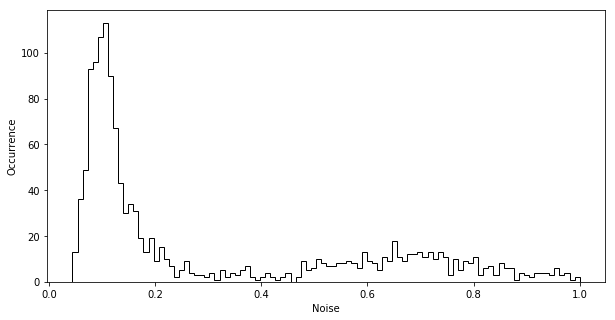

In [7]:
def reject_outliers(data, m = 3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def find_noise(I):
    noise = I - lowpass(I, 3)
    noise = reject_outliers(noise)
    return np.std(noise) 

noise = np.array([find_noise(I_peak[i]) for i in range(n_peak)])

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(noise[noise<1], 100, color='k', histtype='step', lw=1)        
ax.set_xlabel('Noise')
ax.set_ylabel('Occurrence')

# Discard spots with high noise level

In [8]:
noise_cutoff = 0.2

I_mol = [I_peak[i] for i in range(n_peak) if noise[i] < noise_cutoff]
n_mol = len(I_mol)
print('Found %d molecules. Discarded %d spots.' %(n_mol, (n_peak-n_mol)))

Found 857 molecules. Discarded 572 spots.


## Show traces as an example

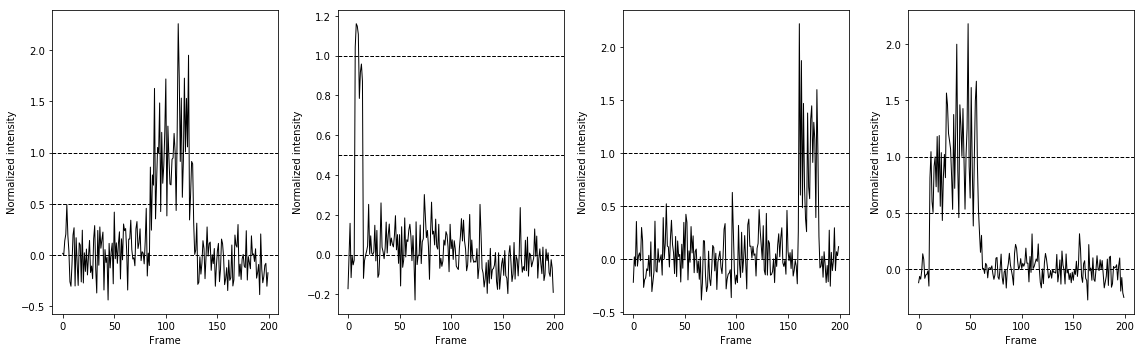

In [9]:
n_fig = 4
fig, ax = plt.subplots(1, n_fig, figsize=(4*n_fig, 5))
for i in range(n_fig):
    ax[i].plot(I_mol[i], 'k', lw=1)
    ax[i].axhline(y=1, ls='--', lw=1, c='k')
    ax[i].axhline(y=0.5, ls='--', lw=1, c='k')
    ax[i].axhline(y=0, ls='--', lw=1, c='k')
    ax[i].set_xlabel('Frame')
    ax[i].set_ylabel('Normalized intensity')
fig.tight_layout()

## Lowpass filter (smothen) the signal 

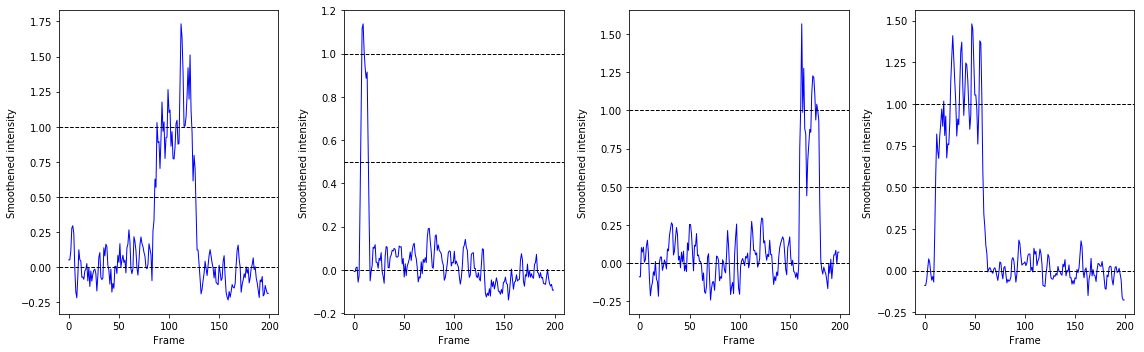

In [10]:
I_lp = [lowpass(I_mol[i], 3) for i in range(n_mol)]

fig, ax = plt.subplots(1, n_fig, figsize=(4*n_fig, 5))
for i in range(n_fig):
    ax[i].plot(I_lp[i], 'b', lw=1)
    ax[i].axhline(y=1, ls='--', lw=1, c='k')
    ax[i].axhline(y=0.5, ls='--', lw=1, c='k')
    ax[i].axhline(y=0, ls='--', lw=1, c='k')
    ax[i].set_xlabel('Frame')
    ax[i].set_ylabel('Smoothened intensity')
fig.tight_layout()

## Find the traces using piecewise constant (PWC) algorithm
### Ref: Generalized Methods and Solvers for Noise Removal from Piecewise Constant Signals (2010)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


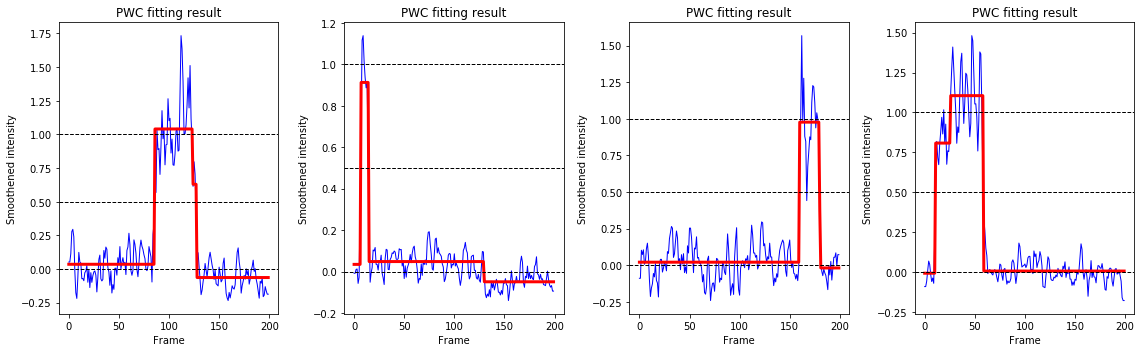

In [11]:
# Use Jump Penalty algorithm among PWC since it is less sensitive to noise. 
from pwc_jumppenalty import pwc_jumppenalty
from pwc_cluster import pwc_cluster

I_fit = ['None']*n_mol
for i in range(n_mol):
    I_fit[i] = pwc_jumppenalty(I_lp[i], square=True, gamma=1.0, display=False, maxiter=10, full=False)
#    I_fit[i] = pwc_cluster(I_mol[i], K=2, soft=False, beta=0.1, biased=True, display=False, stoptol=1e-5, maxiter=20) # Likelihood mean-shift
    
# Plot the fitting result
f, ax = plt.subplots(1, n_fig, figsize=(4*n_fig, 5))
for i in range(n_fig):
    ax[i].plot(I_lp[i], 'b', lw=1)
    ax[i].plot(I_fit[i], 'r', lw=3)    
    ax[i].axhline(y=1, ls='--', lw=1, c='k')
    ax[i].axhline(y=0.5, ls='--', lw=1, c='k')
    ax[i].axhline(y=0, ls='--', lw=1, c='k')
    ax[i].set_xlabel('Frame')
    ax[i].set_ylabel('Smoothened intensity')
    ax[i].set_title('PWC fitting result')
f.tight_layout()

## Define state [unbound, bound] = [0, 1] in each trace based on the PWC fitting result

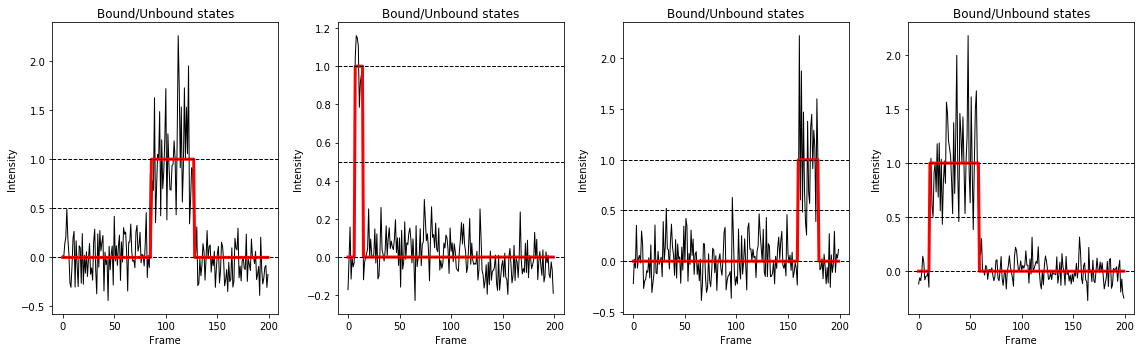

In [12]:
# If I_fit > 0.5, then it is bound state. Otherwise, it is unbound state. 
state = [I_fit[i] > 0.5 for i in range(n_mol)]

# Plot the fitting result
f, ax = plt.subplots(1, n_fig, figsize=(4*n_fig, 5))
for i in range(n_fig):
    ax[i].plot(I_mol[i], 'k', lw=1)    
    ax[i].plot(state[i], 'r', lw=3)    
    ax[i].axhline(y=1, ls='--', lw=1, c='k')
    ax[i].axhline(y=0.5, ls='--', lw=1, c='k')
    ax[i].axhline(y=0, ls='--', lw=1, c='k')
    ax[i].set_xlabel('Frame')
    ax[i].set_ylabel('Intensity')
    ax[i].set_title('Bound/Unbound states')
f.tight_layout()

## Now, we find the dwell time from each trace 

In [13]:
# Variable to save bound and unbound dwell
dwell = []   # Dwell time

for i in range(n_mol):
    t_b = []   # Frame number at binding
    t_u = []   # Frame number at unbinding

    s = state[i] # State of ith molecule
    for j in range(len(s)-1):
        
        # Frame at binding
        if (s[j] == False) & (s[j+1] == True):
            t_b.append(j)
            
        # Frame at unibnding
        if (s[j] == True) & (s[j+1] == False):
            t_u.append(j)    
            
        # Stop if there's no complete binding/unbinding
        if len(t_b)*len(t_u) == 0: 
            continue
        
        # Remove pre-existing binding
        if t_u[0] < t_b[0]: 
            del t_u[0]
            
        # Stop if there's no complete binding/unbinding
        if len(t_b)*len(t_u) == 0: 
            continue            
            
        # Remove unfinished binding    
        if t_u[-1] < t_b[-1]: 
            del t_b[-1]
            
        # Stop if there's no complete binding/unbinding
        if len(t_b)*len(t_u) == 0: 
            continue   
            
        # Dwell time of each molecule
        t_bu = [t_u[k] - t_b[k] for k in range(len(t_b))]
        
    # Dwell time of overall molecules    
    dwell.extend(t_bu)
    
print('%d events are found.' %(len(dwell)))

857 events are found.


## Histogram and mean dwell time 

Text(0.5, 1.0, 'Mean dwell time = 30.9 [frame]')

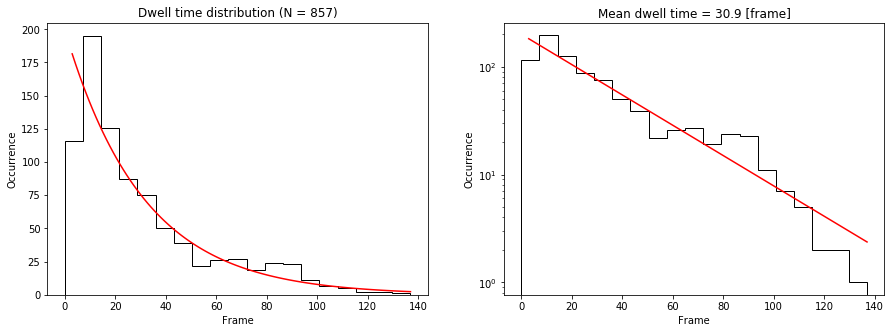

In [14]:
mean_dwell = np.mean(dwell)

bins = np.linspace(0, max(dwell), 20)
norm = len(dwell)*(bins[1]-bins[0])

t = np.linspace(min(dwell), max(dwell), 100)
exp_mean = np.exp(-t/mean_dwell)/mean_dwell
exp_mean = exp_mean*norm

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))    
ax1.hist(dwell, bins, color='k', histtype='step', lw=1)
ax1.plot(t, exp_mean, 'r')
ax1.set_xlabel('Frame')
ax1.set_ylabel('Occurrence')
ax1.set_title('Dwell time distribution (N = %d)' %(len(dwell)))
ax2.hist(dwell, bins, color='k', histtype='step', lw=1)
ax2.plot(t, exp_mean, 'r')
ax2.set_yscale('log')
ax2.set_xlabel('Frame')
ax2.set_ylabel('Occurrence')
ax2.set_title('Mean dwell time = %.1f [frame]' %(mean_dwell))

# Finally, we got the mean dwell time of the entire molecules. 

## Add drift correction
## Jupyter Github
## else?